# VIXM Predictor Feature Importance using an adaBoost Model

### Introduction

This notebook presents a machine learning model designed to predict the direction of returns for the VIXM ETN on the following trading day.
By constructing the algorithm, we can see which features would be more important to predict the movements of the VIXM.

The construction is being improved from an old version as of Jan 2025. It will be ready in a few days.

Next step is to check using other algorithms, tune a final model, and implement the trading strategy.

We extract or calculate a range of features from a predefined list of tickers using Yahoo Finance data. These features include:

- Close prices
- Returns
- Volume
- GARCH models for volatility estimation
- Squared returns
- SPY historical volatility
- Day-of-the-week and month-of-the-year seasonality effects
- Principal components analysis (PCA) lagged by 1 to 5 days, representing historical movements

The feature extraction and model training are organized into two separate modules:
> `vixcoin_functions/feature_functions.py`  
> `vixcoin_functions/pca_and_training.py`

The core of this strategy is powered by the **AdaBoost algorithm**, which generates daily signals (`0` or `1`). These signals dictate the trading strategy:  
- **Buy** VIXM when the signal is `1`  
- **Sell** VIXM when the signal returns to `0`

In addition to signal generation, the code provides the following analyses:
- Profitability assessment of the trading strategy
- Model accuracy evaluation
- Feature importance analysis
- Hyperparameter tuning for optimizing model performance



In [1]:
%load_ext autoreload
%autoreload 2

In [309]:
import sys
from pathlib import Path
import datetime as dt
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

# Add vixcoin_functions to sys.path if not already included
module_path = str(Path("vixcoin_functions/"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import functions from feature_functions and pca_and_training modules
from data_load_and_cleanup import (
    upload_configuration,
    process_data_pipeline
    
)
from feature_functions import (
    garch_fit_and_predict, 
    correlation_filter,
    get_prices_component,
    get_return_component,
    get_volume_component,
    get_garch_component,
    get_return_squared,
    get_ticker_volatilities,
    get_day_of_week_component,
    get_month_component,
    get_X,
    setup_signal,
    shift_signal_for_prediction
)
from pca_and_training import (
    split_training_test_data,
    scale,
    adaboost_pca,
    create_pca_lag,
    get_lagged_pca,
    combine_train_test,
    concatenate_with_pca_lags,
    eliminate_nans_in_pca_data,
    add_pca,
    random_over_sample
)
from visualizations import(
    plot_tickers_with_scaling
)

# Upload Configuration

In [310]:
config = upload_configuration('config.yml', display_configuration=False)

Configuration uploaded succesfully


In [66]:
# Some re-used variables from config
start_date_volatilities = (pd.to_datetime(config['start_date']) + DateOffset(days=364)).date()
start_date = config['start_date']
end_date = config['end_date']
demo_mode = config['demo_mode']
ticker_list = config['ticker_list']
tuning_mode = config['tuning_mode']

print(f"start date: {start_date}")
print(f"end date  : {end_date}")
print(f"rolling volatilities start date: {start_date_volatilities}")
print(f"Current number of tickers: {len(config['ticker_list'])}")

start date: 2011-01-05
end date  : 2025-01-05
rolling volatilities start date: 2012-01-04
Current number of tickers: 29


# Data Upload and Cleanup

In [117]:
data = process_data_pipeline(config, display_detailed_steps=False)

Raw data of prices and volume has been succesfully loaded
For the following tickers:
    Prices: ['VIXM', '^VIX', 'SPY', 'GBPUSD=X', 'BRLUSD=X', 'DX-Y.NYB', 'USDJPY=X', '^TNX', 'ZF=F', 'NQ=F', 'NKD=F', 'LQD', 'AAPL', 'AMZN', 'MU', 'MSFT', 'BMY', 'PLD', 'FXI', 'FEZ', '^FTSE', '^FCHI', '^GSPC', 'GLD', 'SLV', 'ES=F', 'QM=F', 'BIO=F', 'AGG']
    Volume: ['VIXM', '^VIX', 'SPY', 'GBPUSD=X', 'BRLUSD=X', 'DX-Y.NYB', 'USDJPY=X', '^TNX', 'ZF=F', 'NQ=F', 'NKD=F', 'LQD', 'AAPL', 'AMZN', 'MU', 'MSFT', 'BMY', 'PLD', 'FXI', 'FEZ', '^FTSE', '^FCHI', '^GSPC', 'GLD', 'SLV', 'ES=F', 'QM=F', 'BIO=F', 'AGG']

prices data succesfully cleaned
volume data succesfully cleaned
Saved clean_prices.csv to data
Saved clean_volume.csv to data
Saved clean_d_returns.csv to data


# Plot of Prices
Try other characteristics using key = 'volume' or key = 'd_returns'

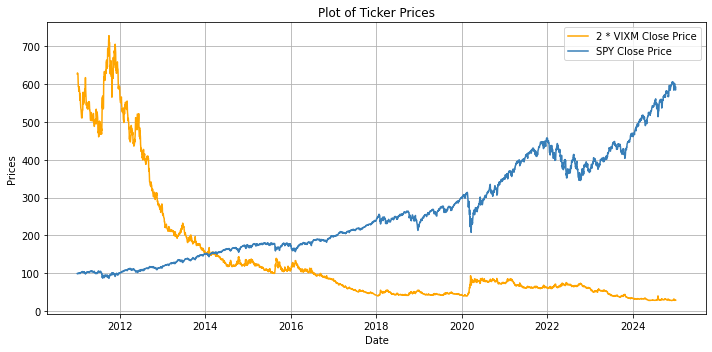

In [68]:
plot_tickers_with_scaling(
            data,
            key='prices',
            as_is_tickers=['SPY'],
            scaled_tickers=['VIXM'],
            scaled_factors=[2]
        )

# Generation of the Features Matrix X

Here we generate the components that will be part of the feature matrix

In [118]:
X_components = {}

### X1: close prices
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [119]:
# get first component X1
X_components[1], vixm, vixm_ret = get_prices_component(
    data['prices'], config, display_results=False)

Calculation of price component completed


### X2: security returns

In [120]:
X_components[2] = get_return_component(
        daily_returns_df=data['d_returns'],
        config=config,
        display_results=False
)

Calculation of returns component completed


### X3: security volume

In [121]:
X_components[3] = get_volume_component(volume_df=data['volume'], config=config,
        vixm_ret=vixm_ret, display_results=False
)

Succesful calculation of security volume component X3


### X4: GARCH Models1
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution of errors

In [122]:
X_components[4] = get_garch_component(
    config=config,
    security_returns_df=data['d_returns'],
    display_results=False
    )

GARCH Process fit and predictions completed for component X4


### X5: Return squared


In [123]:
X_components[5] = get_return_squared(
    config,
    vixm_ret,
    security_returns_df=data['d_returns'],
    display_results=False
    )

Return squared calculation completed for componenent 5 (X5)


### X6: volatility of the SPY in several rolling windows

In [124]:
X_components[6] = get_ticker_volatilities(
    start_date_volatilities=start_date_volatilities,
    vixm=vixm,
    returns=data['d_returns'],
    ticker='SPY',
    config=config,
    display_results=False
)

Rolling volatilities component completed (X6)


### X10: Day of the Week effect

In [125]:
X_components[10] = get_day_of_week_component(
    close_prices_df=data['prices'],
    display_results=False
)

Calculation of day of the week effect component (X10) completed.


### X11: Month effect

In [126]:
X_components[11] = get_month_component(
    close_prices_df=data['prices'],
    display_results=False
)

Calculation of day of the week effect component (X10) completed.


In [127]:
X_components.keys()

dict_keys([1, 2, 3, 4, 5, 6, 10, 11])

# Construction of feature matrix X

In [247]:
X = get_X(X_components,config,inclusion_list=['all'])
X.shape

Component 1: prices included
Component 2: return included
Component 3: volume included
Component 4: garch included
Component 5: return_squared included
Component 6: spy_volatilities_lags included
Component 10: day-of_week_effect included
Component 11: month_effect included


(3392, 151)

# y:  Set the Signal

In [248]:
y, XY = setup_signal(X, config, display_results=True)

Signal value_counts:
Signal
0.0       3046
1.0        346
dtype: int64

XY.shape:  (3392, 152)

VIXM return and signal slide:
             VIXM_ret  Signal
Date                        
2012-01-04 -0.019329     0.0
2012-01-05 -0.005631     0.0
2012-01-06 -0.011468     0.0
2012-01-09 -0.006015     0.0
2012-01-10 -0.007493     0.0
...              ...     ...
2024-12-27  0.021986     1.0
2024-12-30  0.011103     0.0
2024-12-31 -0.007550     0.0
2025-01-02  0.010373     0.0
2025-01-03 -0.017112     0.0

[3392 rows x 2 columns]


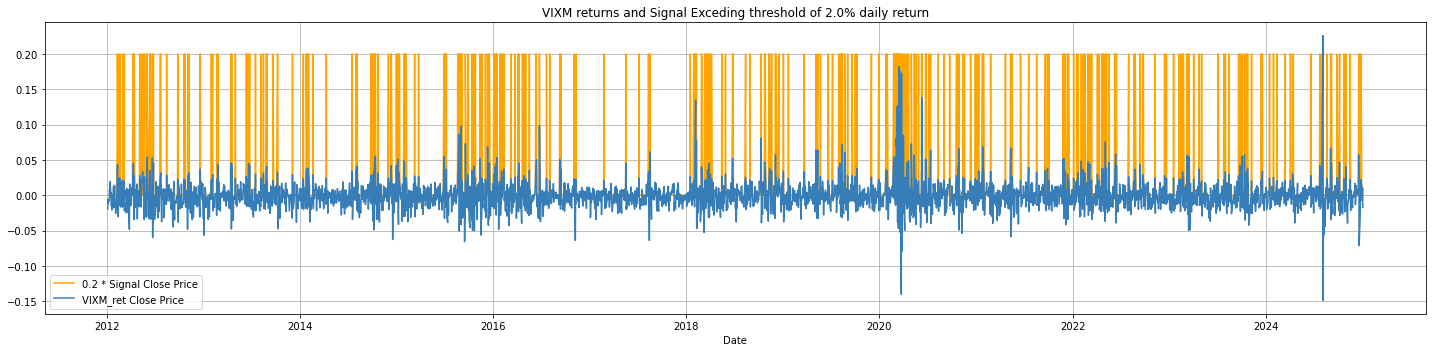

In [249]:
# Plotting return signals exceding the threshold
plot_tickers_with_scaling(
            XY,
            key=None,
            as_is_tickers=['VIXM_ret'],
            scaled_tickers=['Signal'],
            scaled_factors=[0.2],
            height=5,
            wide=20,
            title=f"VIXM returns and Signal Exceding threshold of {100*config['threshold']}% daily return"
        )

**Obs:** the times of higher volatility display a higher density of signals, as expected. Let´s remember that higher returns in absolute value comes in clusters of high volatility.

In [250]:
X, y, prediction_vector = shift_signal_for_prediction(XY, signal_colname="Signal", display_results=False)

In [251]:
# Review of correlations - interactive plot when used with jupyter notebooks or voila
correlations = X.corr()

correlations.hvplot.heatmap(
    cmap='coolwarm', 
    title='Feature Correlation Heatmap', 
    width=1500, 
    height=1500,
    rot=90,
    colorbar=True
)

:HeatMap   [columns,index]   (value)

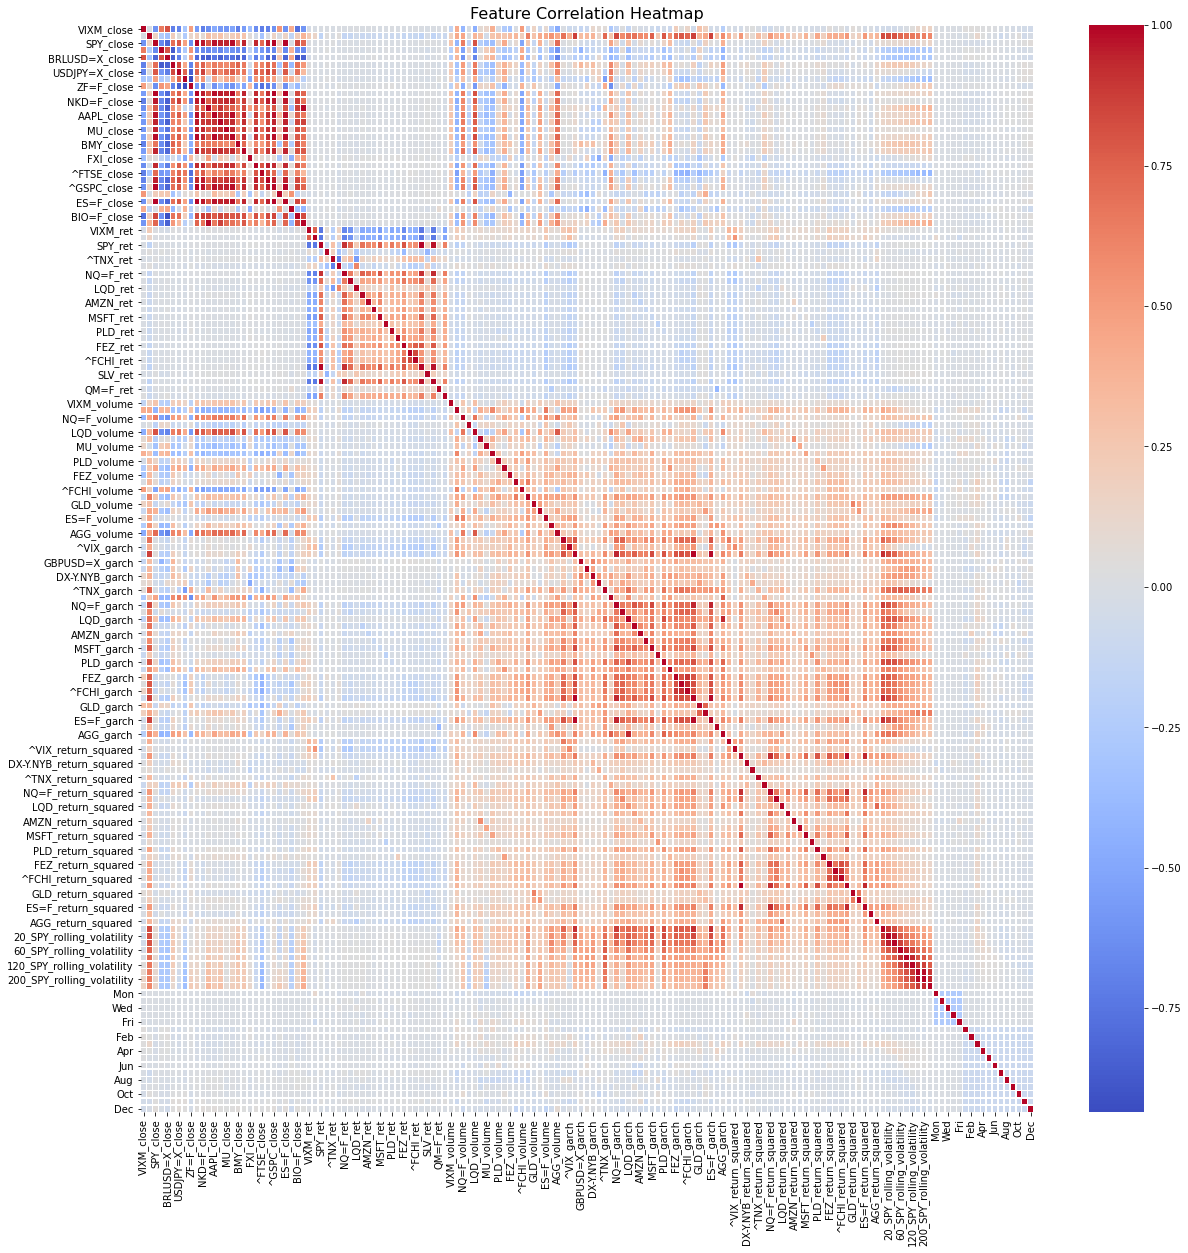

In [252]:
# Compute correlation matrix - Static plot - Made too be able to see in GitHub
correlations = X.corr()

# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlations,
    cmap='coolwarm',
    annot=False,         # Show correlation values
    fmt=".2f",          
    linewidths=0.5,     
    cbar=True
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


# Split of data in Train and Test (I) and Scaling

In [256]:
# Split data into training and testing subsets
X_train, y_train, X_test, y_test = split_training_test_data(
    X, y, training_period_months=config['training_period_months'], display_results=False)


Time series data split completed


In [259]:
# Scaling of the data -- added
X_train_scaled, X_test_scaled = scale(
    X_train, X_test, scaler_type='MinMaxScaler', display_results=False)

Data scaled succesfully


### X lags: calculate principal components of Train data, and lagged them 
Number of components to add are given in the config. As of now, 6 coomponents with lags of 5 days.
That means, that data up to the previous week is included, but instead of adding all the features, we select just
the 6 first principal components which represent more than 50% of the variance in the data.

X_train_scaled shape: (2610, 151)
X_test_scaled shape: (781, 151)
Data scaled succesfully, based on trained data.
Explained variance of first 6 components: 57.15%
Explained variance ratio per component: 


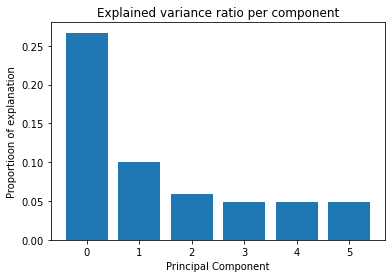

Principal components shape: (3391, 6)
                pca1      pca2      pca3      pca4      pca5      pca6
Date                                                                  
2012-01-04 -1.670419  1.237624 -0.476239 -0.023815 -0.421198 -0.048959
2012-01-05 -1.672802  1.254057 -0.429745 -0.239042 -0.182002  0.789567
2012-01-06 -1.663718  1.243238 -0.401727 -0.634845  0.555131 -0.309391
2012-01-09 -1.652909  1.197620 -0.494791  0.727910  0.503087  0.076556
2012-01-10 -1.636548  1.200962 -0.497547  0.127860 -0.486587 -0.524197
Lagged components shape 1: (3391, 5)
            pca1_lag1  pca2_lag1  pca3_lag1  pca4_lag1  pca5_lag1
Date                                                             
2012-01-04        NaN        NaN        NaN        NaN        NaN
2012-01-05  -1.670419   1.237624  -0.476239  -0.023815  -0.421198
2012-01-06  -1.672802   1.254057  -0.429745  -0.239042  -0.182002
2012-01-09  -1.663718   1.243238  -0.401727  -0.634845   0.555131
2012-01-10  -1.652909   1.197620

Index(['VIXM_close', '^VIX_close', 'SPY_close', 'GBPUSD=X_close',
       'BRLUSD=X_close', 'DX-Y.NYB_close', 'USDJPY=X_close', '^TNX_close',
       'ZF=F_close', 'NQ=F_close',
       ...
       'pca1_lag4', 'pca2_lag4', 'pca3_lag4', 'pca4_lag4', 'pca5_lag4',
       'pca1_lag5', 'pca2_lag5', 'pca3_lag5', 'pca4_lag5', 'pca5_lag5'],
      dtype='object', length=176)

In [319]:
X_pc = add_pca(X=X, X_train=X_train, X_test=X_test, 
    n_components=config["num_pca_components"], 
    t=config["num_lags_to_include"], 
    scaler_type='MinMaxScaler',
    display_results=True
)
X_pc.columns

# Split the extended data in train and test
pca were calculated on training data only

In [295]:
X.shape, y.shape

((2759, 165), (2764,))

In [296]:
# Split of data in train and test, applying temporal window function that respect time series order

# Split the data
X_train, y_train, X_test, y_test = split_training_test_data(
    X, y, training_period_months=training_period_months
)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled and X_test_scaled contain the scaled data


            VIXM_close  ^VIX_close  SPY_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2014-03-03    0.982745    0.066077   0.009492        0.927112        0.905663   
2014-03-04    1.000000    0.093270   0.006367        0.932884        0.896440   
2014-03-05    0.972520    0.067437   0.012570        0.923436        0.891556   
2014-03-06    0.968685    0.064582   0.012975        0.923219        0.893645   
2014-03-07    0.961655    0.068933   0.014001        0.931319        0.906759   

            DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2014-03-03        0.018301        0.042598    0.480953    0.762005   
2014-03-04        0.026594        0.027039    0.469592    0.770768   
2014-03-05        0.029168        0.029107    0.488305    0.757799   
2014-03-06        0.027738        0.043912    0.489864    0.756747   
2014-03-07  

In [297]:
# Generate a list of column names based on the length of X's columns
column_name_list = [f"f_{i}" for i in range(len(X.columns))]

# Copy X_train and assign new column names
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [298]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train, tuning_mode=tuning_mode)


y_train_resampled value_counts: 0.0    1382
1.0    1382
Name: Signal, dtype: int64


# Adaboost Model Estimation

In [299]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model = AdaBoostClassifier(  
    base_estimator=base,
    n_estimators=adaboost_estimators,
    learning_rate=learning_rate_adaboost,
    random_state=4
)
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.7, n_estimators=6, random_state=4)

In [300]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

In [306]:
if demo_mode == False and tuning_mode:
    print("nulls in y_test: ", y_test.isnull().sum())
    display(y_test[y_test.isnull()])
    display(np.all(np.isfinite(y_test)))
    display(y_test.shape)
print("X_test nulls:")
X_test.isnull().sum().sum()

nulls in y_test:  1


Date
2024-09-26   NaN
Freq: B, Name: Signal, dtype: float64

False

False

True

(149,)

(149,)

X_test nulls:


0

In [312]:
X_test_original = X_test
y_test_original = y_test

In [313]:
# Eliminating Nulls
null_ytest_idx = y_test[y_test.isnull()].index

# Dropping the nulls in both X_test and y_test
X_test = X_test.drop(index=null_ytest_idx)
y_test = y_test.drop(index=null_ytest_idx)

# Optionally print the result for verification
print(f"Cleaned X_test shape: {X_test.shape}")
print(f"Cleaned y_test shape: {y_test.shape}")


Cleaned X_test shape: (148, 165)
Cleaned y_test shape: (148,)


In [317]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

# Predict with the model
pred_adaboost = adaboost_model.predict(X_test)
pred_tomorrow = pred_adaboost[-1]
pred_tomorrow

1.0

In [318]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57        74
         1.0       0.58      0.61      0.59        74

    accuracy                           0.58       148
   macro avg       0.58      0.58      0.58       148
weighted avg       0.58      0.58      0.58       148



# Analysis of feature importance in the AdaBoost model

In [322]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients = adaboost_model.feature_importances_

feature_importance_df = pd.Series(
    adaboost_importance_coeficients, 
    index=X.columns
)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
n_important_features = feature_importance_df.loc[feature_importance_df > 0].shape[0]
feature_importance_df.loc[feature_importance_df > 0].hvplot(
    kind='barh', 
    height=500,
    title= f"{n_important_features} Features relevant for the VIXM Prediction Model"
)

Feature: 30, ^VIX_returns, Score: 0.13411155680511969
Feature: 45, ^FTSE_returns, Score: 0.04486359669800899
Feature: 47, ^GSPC_returns, Score: 0.07252350751061915
Feature: 51, BIO=F_returns, Score: 0.06909186504277537
Feature: 56, MSFT_volume, Score: 0.03571217190041094
Feature: 59, ^FTSE_volume, Score: 0.03717444185045868
Feature: 66, SPY_garch, Score: 0.06423483213129137
Feature: 71, ^TNX_garch, Score: 0.05240223513089784
Feature: 79, MSFT_garch, Score: 0.05926086861595379
Feature: 93, ^VIX_return_squared, Score: 0.22008296974257102
Feature: 94, SPY_return_squared, Score: 0.05893581967466138
Feature: 102, AAPL_return_squared, Score: 0.04174092402514967
Feature: 114, SLV_return_squared, Score: 0.03333996949259993
Feature: 124, 180_spy_rolling_volatility, Score: 0.03619133783599612
Feature: 156, pca4_lag3, Score: 0.04033390354348603


:Bars   [index]   (0)

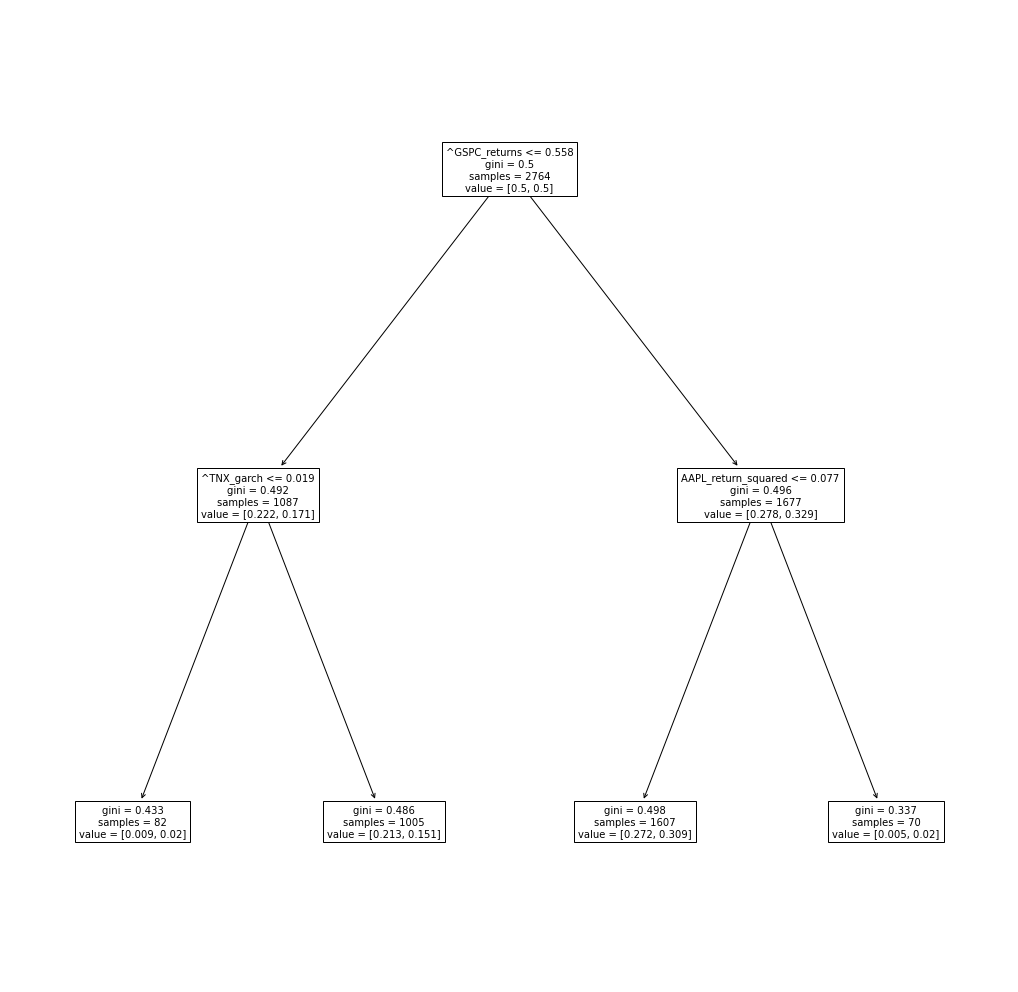

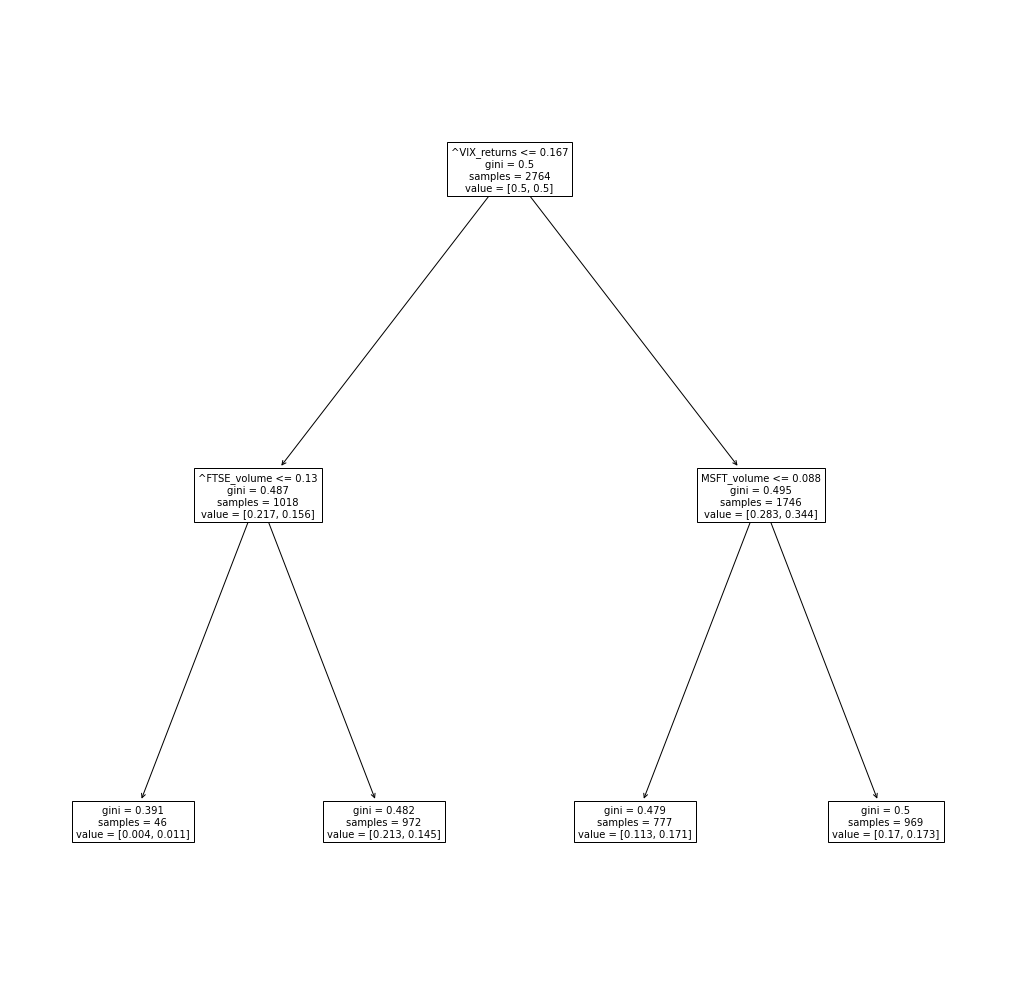

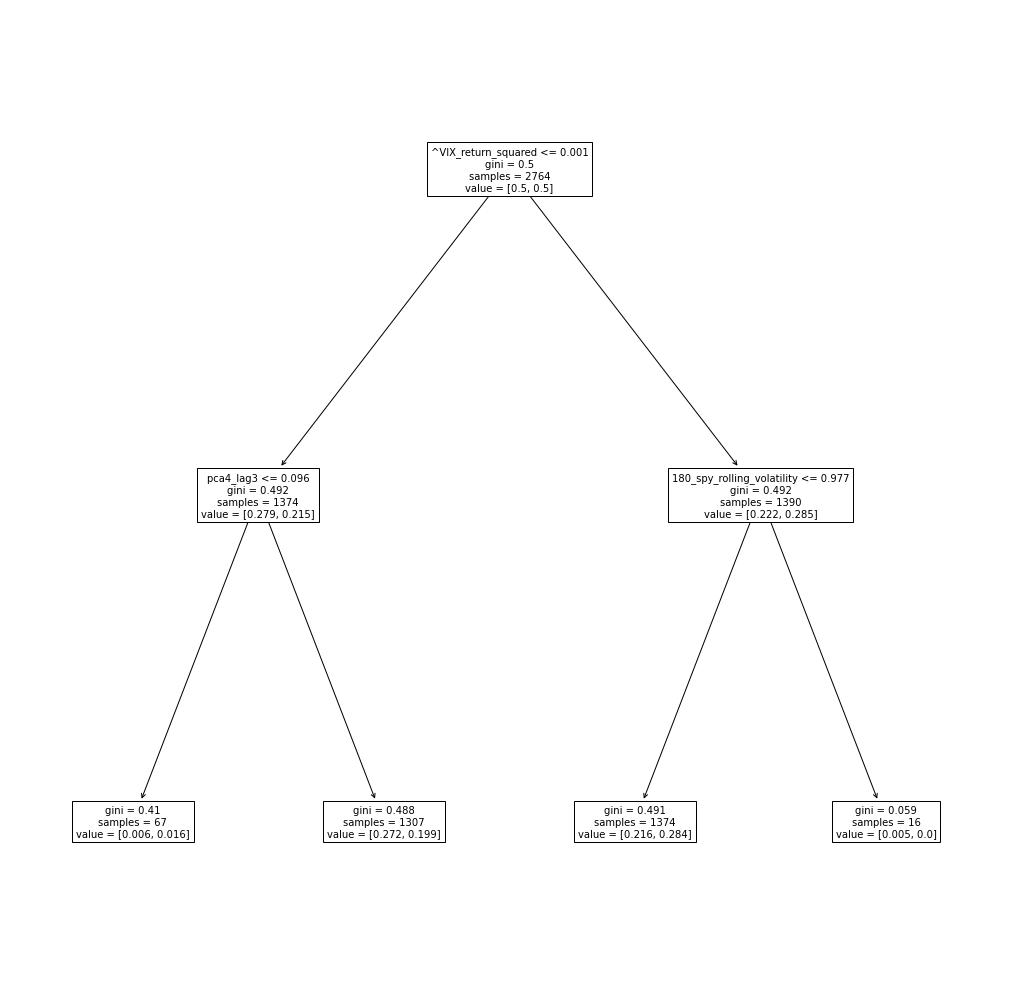

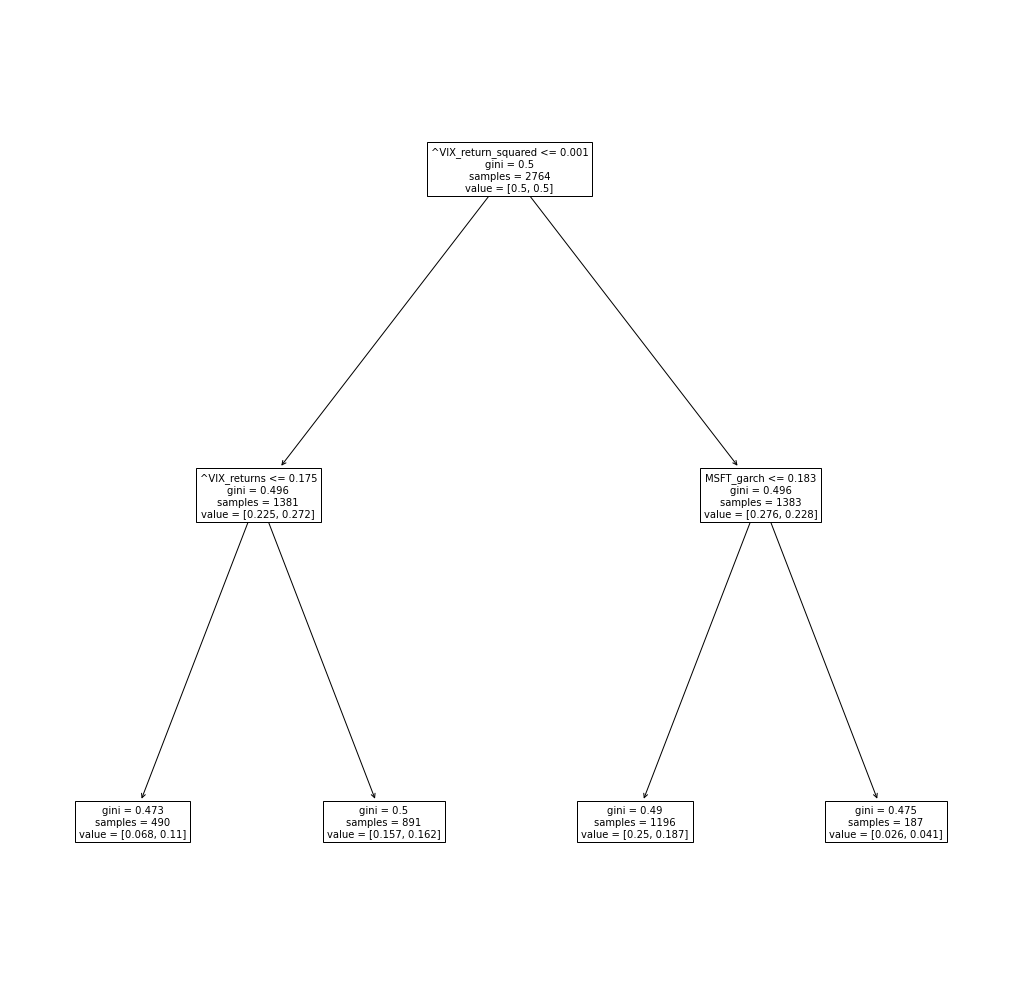

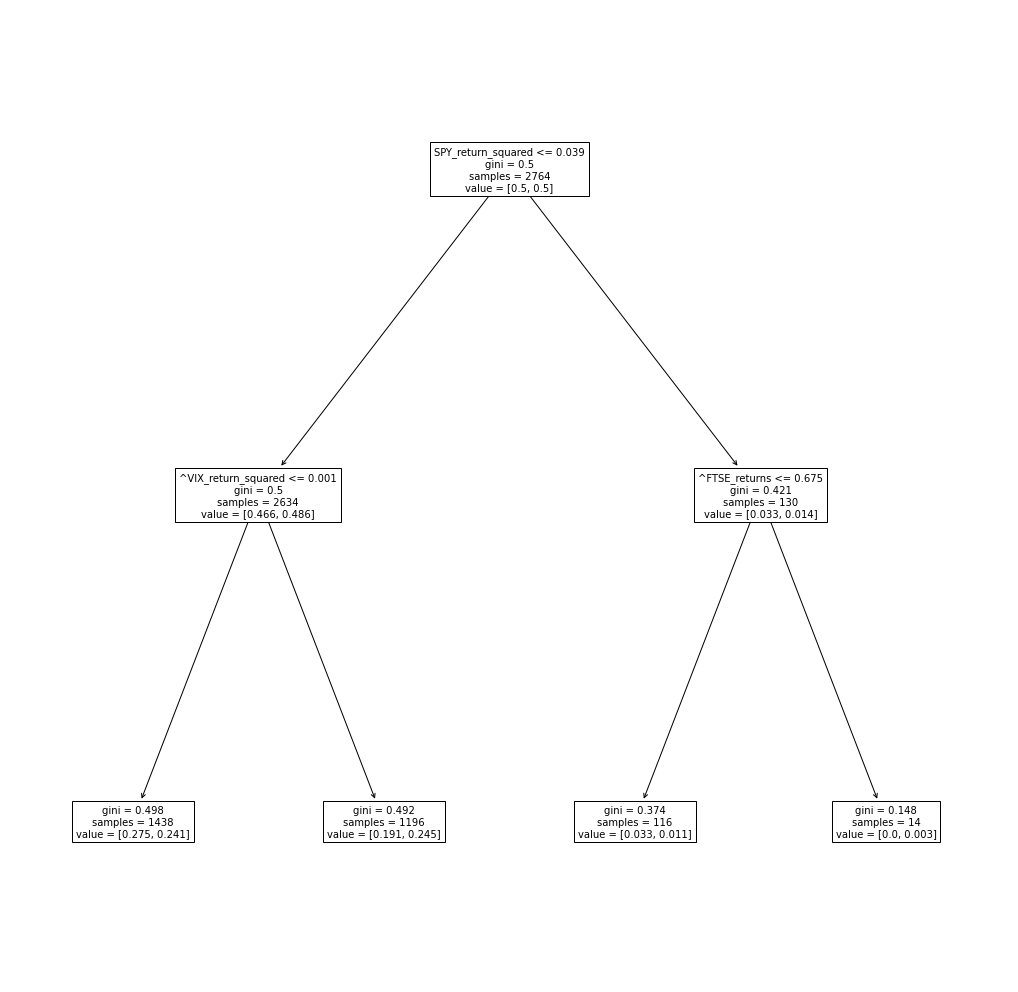

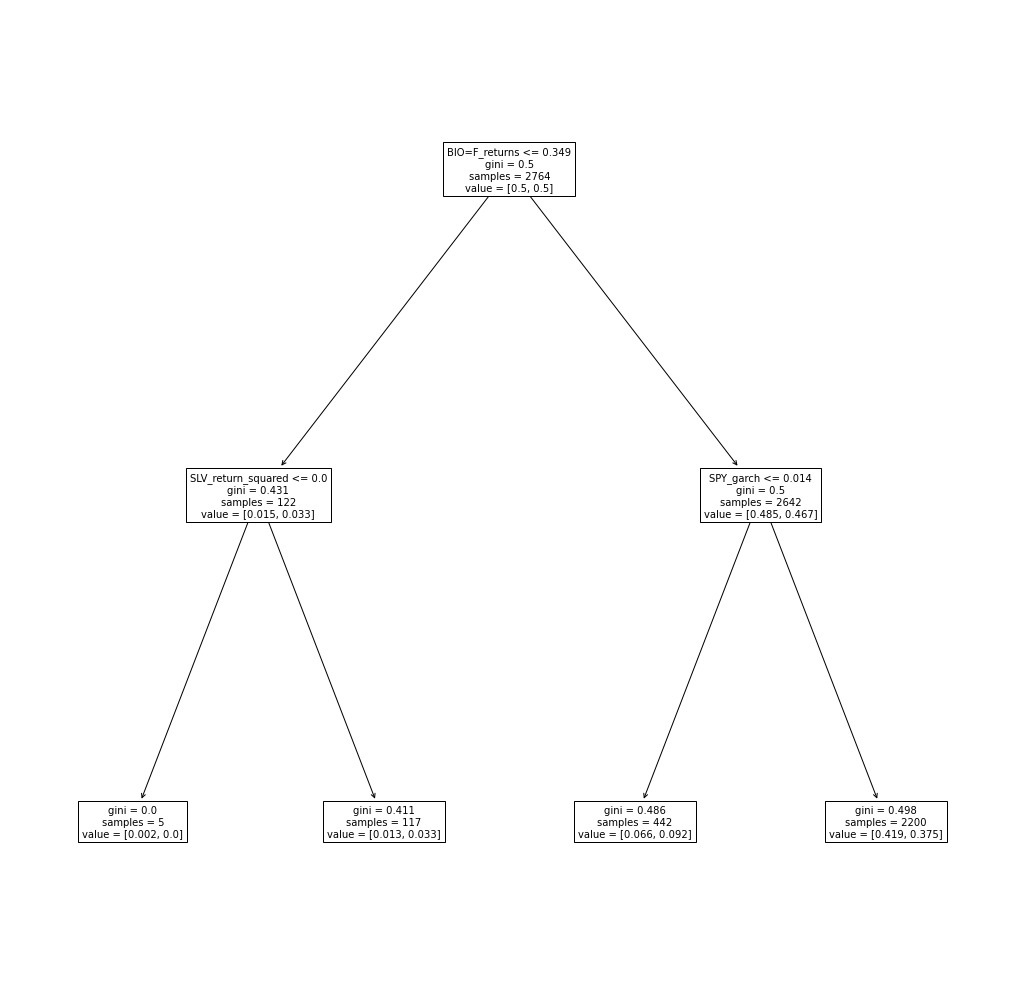

In [320]:
#import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i], fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis


In [48]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics = abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2900.000000
mean        1.395715
std         1.501480
min         0.000000
25%         0.434465
50%         0.994112
75%         1.875514
max        18.214719
Name: VIXM, dtype: float64

In [49]:
#vixm_ret.loc['2011-02-21']
#y_train_df.index.min()  
#y_train_df.index.max()

### In-sample analysis: Return on $1 invested on training data window

In [50]:
# Results comnparison

# Profitability on the train window
fit_train = adaboost_model.predict(X_train_scaled)
fit_train_df = pd.DataFrame(fit_train, index = X_train.index)

fit_train_df.hvplot()

y_train_df = pd.DataFrame(y_train, index=X_train.index)

vixm_returns_train_df = vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


# SPY as benchmark
spy_in_sample_period_returns = security_returns_component_df['spy'].loc[y_train_df.index.min():y_train_df.index.max()]


results_train_df = pd.concat([vixm_returns_train_df, y_train_df, fit_train_df, spy_in_sample_period_returns], axis=1)
print(results_train_df)

results_train_df.columns = ['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY returns"]

predicted_return = np.multiply(results_train_df['VIXM Return'],results_train_df['Fit Signal'])
max_return = np.multiply(results_train_df['VIXM Return'],results_train_df['Correct Signal'])


results_train_df = pd.concat([results_train_df, predicted_return, max_return], axis=1)
print(results_train_df)

results_train_df.columns = ['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY Return", 'VIXCOIN Token Return', "Max Return"]


return_of_one_dollar_in_train_window_df = (1+results_train_df[['VIXM Return', "SPY Return", 'VIXCOIN Token Return', "Max Return"]]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM ETN', "SPY Return", 'VIXCOIN Token(in sample)', "Max Return"]

profitability_train_plot=return_of_one_dollar_in_train_window_df[['VIXCOIN Token(in sample)','VIXM ETN' ]].hvplot(
                                             title="In-Sample Growth of $1 initial Investment in VIXCOIN Token",
                                             ylabel="Dollars $" ,
                                             width=1000,
                                             color=['green','red','blue']
 )

profitability_train_plot
#results_train_df[["Correct Signal", "Fit Signal"]].head(20)
#(1+predicted_return).cumprod().tail(400)
#return_of_one_dollar_in_train_window_df.tail()

            VIXM_ret  Signal    0       spy
Date                                       
2011-02-21  0.000000     1.0  1.0  0.000000
2011-02-22  0.059293     1.0  0.0 -0.020070
2011-02-23  0.026566     1.0  1.0 -0.006145
2011-02-24  0.001107     1.0  1.0 -0.000687
2011-02-25 -0.035941     0.0  1.0  0.010693
...              ...     ...  ...       ...
2021-02-15  0.000000     1.0  1.0  0.000000
2021-02-16  0.001446     1.0  1.0 -0.000866
2021-02-17 -0.001925     0.0  0.0  0.000229
2021-02-18  0.011333     1.0  1.0 -0.004256
2021-02-19  0.000477     1.0  0.0 -0.001766

[2610 rows x 4 columns]
            VIXM Return  Correct Signal  Fit Signal  SPY returns         0  \
Date                                                                         
2011-02-21     0.000000             1.0         1.0     0.000000  0.000000   
2011-02-22     0.059293             1.0         0.0    -0.020070  0.000000   
2011-02-23     0.026566             1.0         1.0    -0.006145  0.026566   
2011-02-24   

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [51]:
y_train_df.index

DatetimeIndex(['2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24',
               '2011-02-25', '2011-02-28', '2011-03-01', '2011-03-02',
               '2011-03-03', '2011-03-04',
               ...
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19'],
              dtype='datetime64[ns]', name='Date', length=2610, freq='B')

### Out-of--sample analysis: Return on $1 invested on training data window

In [52]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test = adaboost_model.predict(X_test)
prediction_test_df = pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df = pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df = vixm_ret.loc[y_test_df.index.min() : y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return = results_test_df['VIXM Return'] * results_test_df['Predicted Signal']
max_return = results_test_df['VIXM Return'] * results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns = security_returns_component_df['spy'].loc[y_test_df.index]

# DataFrame with out-of-sample results for comparison
results_test_df = pd.concat(
    [results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], 
    axis=1
)
results_test_df.columns = [
    'VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"
]

return_of_one_dollar_in_test_window_df = (
    1 + results_test_df[['Predicted Return','VIXM Return',  "Benchmark: SPY"]]
).cumprod()
return_of_one_dollar_in_test_window_df.columns = [
    'VIXCOIN Token (out of sample)', 'VIXM ETN', 'Benchmark: SPY ETF']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
roi_token = -1 + return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].iloc[-1]
roi_etn = -1 + return_of_one_dollar_in_test_window_df['VIXM ETN'].iloc[-1]
roi_spy = -1 + return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].iloc[-1]

title = f" Growth of $1 investment in VIXCOIN Token since October 2019.    Token Return: {roi_token*100:.1f}%  ETN Return: {roi_etn*100:.1f}% SPY Return: {roi_spy*100:.1f}%"
profitability_test_plot = return_of_one_dollar_in_test_window_df.hvplot(
    title=title,
    ylabel= "Dollars $",
    width=1200,
    height=500,
    color=["green","red","blue"]
    #,legend="bottom"
)

profitability_test_plot

#predicted_return.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [53]:
y_test.index

DatetimeIndex(['2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05',
               ...
               '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14'],
              dtype='datetime64[ns]', name='Date', length=276, freq='B')

In [54]:
# Bar graph comparison of returns
start_date_plot = str(results_test_df.index[0].date())
title = f"Out-of-Sample Cummulative Return on Investment Comparison. Starting period: {start_date_plot}"
roi_plot_df = (100*return_of_one_dollar_in_test_window_df)
roi_plot_df.columns = ["VIXCOIN Token", "VIXM ETN", "SPY ETF"]
roi_plot_df = roi_plot_df.iloc[-1]

roi_plot_df.hvplot(
    kind='bar',
    ylabel='Return (%)',
    title=title
    )


:Bars   [index]   (2022-03-14 00:00:00)

In [55]:
# Token growth in out-of.sample window. Like a pricing example if token is set to $1 at the start of the testing window
# Generating a plot that contains the growth of the Token compared to the SPY since Oct 2019. 
# Key points are marked "^" to emphasize levels like maximum, minimum, first, last.

# Set plot and style options
roi_token = (1 + predicted_return).cumprod()[-1]
title = f"VIXCOIN Token Pricing example, if initiated in Feb 2021.                Current price: {roi_token:.2f}"

token_price_curve_plot = return_of_one_dollar_in_test_window_df.hvplot(
    y=['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF'],
    title=title,
    ylabel="Dollars $",
    width=1100,
    color=["green","blue"]
)

first_point = return_of_one_dollar_in_test_window_df.head(1)
last_point = return_of_one_dollar_in_test_window_df.tail(1)
max_token = return_of_one_dollar_in_test_window_df[
    return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'] == 
    return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].max()].head(1)
min_spy = return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'] == 
    return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].min()].head(1)

key_points = pd.concat([first_point, min_spy, max_token, last_point], axis=0)
key_points_token = key_points['VIXCOIN Token (out of sample)']
key_points_spy = key_points['Benchmark: SPY ETF']

token_key_point=return_of_one_dollar_in_test_window_df[
    ['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF']
    ].loc[key_points.index].hvplot(
        kind='scatter',
        marker="^",
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400,
        color=['green','blue']
)

token_key_point*token_price_curve_plot


:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Scatter   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [56]:
key_points.index

DatetimeIndex(['2021-02-22', '2021-03-04', '2022-03-14', '2022-03-14'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
prediction_plot = (
    prediction_test_df.hvplot(
        width=1200,
        kind='bar',
        color=['black']
    ) *
    (5 * vixm_returns_df).hvplot(
        kind='bar',
        color=["yellow"],
        title="How the algorithm avoids time decay?",
        ylabel="Signal and VIXM x5 Return"
    )
)

prediction_plot

In [ ]:
# TOKEN PRICE and JSON FILE

# Set date_start_token and calculate date_after_start_token dynamically
date_start_token = '2020-12-31'
date_start_token_dt = datetime.strptime(date_start_token, '%Y-%m-%d')
date_after_start_token = (date_start_token_dt + timedelta(days=1)).strftime('%Y-%m-%d')

# Output for JSON
# CSV file with [token value, VIXM, SPY] for all history
y_hat_df = pd.concat([fit_train_df, prediction_test_df], axis=0)
y_hat_df.columns = ['Signal_hat']
jason_df = pd.concat([y_hat_df, X2['VIXM_returns'], X2['spy_returns'], X1['VIXM_close'], X1['spy_close']], axis=1)

# Calculate growth of $1 investment
growth_1dollar_investment_df = (1 + jason_df[['VIXM_returns', 'spy_returns']]).cumprod()
print(growth_1dollar_investment_df)
growth_1dollar_investment_df.rename(
    {'VIXM_returns': 'VIXM_growth_1dollar', 'spy_returns': 'spy_growth_of_1dollar'}, 
    axis=1, inplace=True
)

# Concatenate growth data into the main DataFrame
jason_df = pd.concat([jason_df, growth_1dollar_investment_df], axis=1)
jason_df["Signal_hat"] = jason_df["Signal_hat"].fillna(0)

# Calculate Token returns and growth
token_returns = np.multiply(jason_df['Signal_hat'], jason_df['VIXM_returns'])
token_returns.fillna(0, inplace=True)
token_growth_df = (1 + token_returns).cumprod()

# Set Token price
token_price_df = token_growth_df.copy()
token_price_df[token_price_df.index < date_start_token] = 0
token_price_df[token_price_df.index >= date_start_token] = (
    token_growth_df[token_growth_df.index >= date_start_token] / 
    token_growth_df[date_start_token]
)

# Concatenate Token data into the main DataFrame
jason_df = pd.concat([jason_df, token_returns.rename('Token_returns'), token_growth_df.rename('VIXCOIN_token_growth_1dollar'), token_price_df.rename('Token_price')], axis=1)
print(f"jason_df: {jason_df}")

# Update column names
jason_df.columns = [
    'Signal_hat', 'VIXM_returns', 'spy_returns', 'VIXM_close', 'spy_close',
    'VIXM_growth_1dollar', 'spy_growth_of_1dollar', 'Token_returns',
    'VIXCOIN_token_growth_1dollar', 'Token_price'
]

# Drop NaN values and output to CSV
jason_df.dropna().to_csv("demo_data/Jason_output_file.csv", index=True)

# Token graph: Growth of SPY and VIXM, compared to the token price
spy_growth_vs_token = pd.DataFrame(
    (1 + security_returns_df.loc[date_after_start_token:, ['spy', "VIXM"]]).cumprod(),
    index=security_returns_df.loc[date_start_token:, 'spy'].index
)
spy_growth_vs_token.loc[date_start_token, ['spy', "VIXM"]] = 1
spy_growth_vs_token['Token'] = jason_df.loc[date_start_token:, 'Token_price']

# Plot Token price vs VIXM and SPY
token_price_vs_vixm = spy_growth_vs_token.iloc[:, 1:3]

end_date = spy_growth_vs_token.index[-1].strftime('%Y-%m-%d')
title = f"VIXCOIN Token Price. Price as of {end_date}: ${token_price_df.iloc[-1]:.2f}"

graph2 = token_price_vs_vixm.hvplot(
    legend='bottom',
    title=title,
    height=500,
    ylabel="$",
    color=['red', 'green']
)

display(graph2)

spy_growth_vs_token

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Should not be used in a buy and hold strategy.
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [ ]:
# Results in prediction of daily returns
min_return = threshold
results_test_for_plot_df = results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
    y=['VIXM Return', 'Predicted Return'],
    title="Out-of-sample predictions of VIXM return",
    width=1000,
    ylabel='Daily Return (%)'
)

In [ ]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIXM returns predictions"
)

### Analysis of good and bad predictions

In [ ]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[
    results_test_df['Correct Signal'] == results_test_df['Predicted Signal']
]

bad_predictions = results_test_df[
    results_test_df['Correct Signal'] != results_test_df['Predicted Signal']
]

In [ ]:
good = good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIX Returns of Good Predictions"
)

bad = bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [ ]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Box Plot predictions for good and bad predictions
good_pred = good_predictions['Predicted Return']
bad_pred = bad_predictions['Predicted Return']

predictions_comparison_df = pd.concat(
    [good_predictions['Predicted Return'],bad_predictions['Predicted Return']], 
    axis=1, 
    ignore_index=True
)*100
predictions_comparison_df.hvplot(
    kind='box',
    height=800,
    ylabel='Return (%)',
    #clabel=['Good Predictions', 'Bad Predictions'],
    cmap=['blue','red'],
    title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots"
)

#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

#n_estimators 22, Trying deph 1, learning rate 1.8 -- get to perfect accuracy.